<a href="https://colab.research.google.com/github/sanath95/Responsible-AI/blob/main/Responsible_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Responsible AI - Predicting Healthcare Test Results

---

## Introduction

The concept of **Responsible AI** refers to artificial intelligence systems that prioritize fairness, transparency, security, privacy, and accountability while ensuring they benefit humanity. These systems should be free from bias, explainable, safe, and aligned with ethical standards.

In this notebook, we develop a **Responsible AI** system to predict healthcare test results using a [healthcare dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset?resource=download). By applying the principles of Value-Based Engineering, our goal is to create an AI system that upholds human and social values while minimizing negative impacts.

### Principles of Responsible AI

Key principles guiding this AI system include:
- Fairness and justice
- Transparency and explainability
- Security and safety
- Privacy protection
- Responsibility and accountability
- Avoidance of AI hallucinations
- Ensuring human oversight, societal benefit, respect for human rights, and prevention of harm

### EU AI Act: Risk Classification of AI Systems

Under the EU AI Act, healthcare AI systems fall under the **High Risk** category (Annex 3). This system adheres to the following high-risk requirements outlined in Article 8 of the EU AI Act:
- Risk management (Art. 9)
- Data and data governance (Art. 10)
- Technical documentation (Art. 11)
- Transparency (Art. 13)
- Human oversight (Art. 14)

---

In [1]:
# !pip install catboost
# !pip install shap
# !pip install lime

In [2]:
import pandas as pd
from scipy.stats import chi2_contingency
from gensim.models import Word2Vec
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
from copy import deepcopy
import shap
import lime
import hashlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/healthcare_dataset.csv')

---

## Datasheet

### Dataset

[Healthcare Dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset?resource=download)

This synthetic healthcare dataset is designed to simulate real-world healthcare data, providing a safe platform for data science, machine learning, and analysis practice without the risk of personal information being leaked. However, for the purposes of this project, we will approach it as if it contains real-world data and demonstrate risk management techniques. This will include strategies to protect members' personal information from potential adversaries, ensuring privacy and security.

### Overview

- Number of Samples: 55500
- Number of Features: 14
    - Numeric: 3 features
    - Categorical: 11 features
- Target Variable: "Test Results"
    - Categorical: Normal, Abnormal, and Inconclusive
- Null values: 0

### Features

| Column Name        | Description	                                                                       | Data Type | Example         |
|--------------------|-------------------------------------------------------------------------------------|-----------|-----------------|
| Name               | Name of the patient associated with the healthcare record                           | string    | Bobby JacksOn   |
| Age                | Age of the patient at the time of admission(in years)                               | int       | 30              |
| Gender             | Gender of the patient                                                               | string    | Female          |
| Blood Type         | Blood type of the patient                                                           | string    | A+              |
| Medical Condition  | Primary medical condition or diagnosis associated with the patient                  | string    | Diabetes        |
| Date of Admission  | Date on which the patient was admitted to the healthcare facility                   | string    | 2024-01-31      |
| Doctor             | Name of the doctor responsible for the patient's care during their admission        | string    | Matthew Smith   |
| Hospital           | Healthcare facility or hospital where the patient was admitted                      | string    | Sons and Miller |
| Insurance Provider | Insurance provider of the patient                                                   | string    | Aetna           |
| Billing amount     | Amount of money billed for the patient's healthcare services during their admission | float     | 18856.281306    |
| Room Number        | Room number where the patient was accommodated during their admission               | int       | 328             |
| Admission Type     | Type of admission, reflecting the circumstances of the admission                    | string    | Emergency       |
| Discharge Date     | Date on which the patient was discharged from the healthcare facility               | string    | 2024-02-02      |
| Medication         | Medication prescribed or administered to the patient during their admission         | string    | Aspirin         |
| Test Results       | The results of a medical test conducted during the patient's admission              | string    | Normal          |

### Data Quality & Considerations

- *No missing Values:* The dataset does not contain any missing values.
- *Balanced Data:* The target variable (test results) is balanced with approximately equal number of records for each class.
- *Bias & Fairness Considerations:* Gender and age disparities could influence healthcare outcomes, necessitating fairness analysis.

### Use Cases:

- Practice data cleaning, transformation, visualization, and analysis techniques.
- Develop and test healthcare predictive models by framing it as a multi-class classification problem, focusing on "Test Results."
- Apply risk management strategies and data governance practices.
- Experiment with accountability tools, privacy-enhancing methods, and fairness measures for AI.
- Build a "responsible AI" system aimed at enhancing human health, safety, and protecting fundamental rights.

---

In [5]:
# shape of the dataframe
df.shape

(55500, 15)

In [6]:
# display first 5 rows
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [7]:
# check for null values
df.isnull().any().any().item()

False

In [8]:
# check data type of each column
df.dtypes

,0
Name,object
Age,int64
Gender,object
Blood Type,object
Medical Condition,object
Date of Admission,object
Doctor,object
Hospital,object
Insurance Provider,object
Billing Amount,float64


In [9]:
# check class balance
df['Test Results'].value_counts()

,count
Test Results,
Abnormal,18627
Normal,18517
Inconclusive,18356


---

## Exploratory Data Analysis

### Categorical Features
- There are 11 categorical features in the dataset.
- Among these, 'Name,' 'Date of Admission,' 'Doctor,' 'Hospital,' and 'Discharge Date' have a large number of unique categories.
- A chi-square test against the target variable (Test Results) shows that the following features are statistically significant:

|Feature|p-value|
|---|---|
|Name|5.4e-112|
|Date of Admission|	1.5e-16|
|Doctor|	5.1e-121|
|Hospital|	1.4e-107|
|Discharge Date|	3.4e-11|

- The remaining categorical variables are evenly distributed across all classes of Test Results.

### Numeric Features

- The dataset contains 3 numeric features.
- These features show very weak correlations with the target variable.
- Histograms reveal that the distribution of these numeric features is quite similar across all Test Result classes.

### Data Leakage

- The "Discharge Date" feature could lead to data leakage, as it contains information that would not be available at the time of prediction. Therefore, this feature should be excluded from model training.

---

In [10]:
# convert to lower case to reduce the number of unique categories

df['Name'] = df['Name'].str.lower()
df['Hospital'] = df['Hospital'].str.lower()
df['Doctor'] = df['Doctor'].str.lower()

In [11]:
# check for number of unique categories

for col in df.columns:
    if df[col].dtype == 'O':
      print(col, df[col].nunique())

Name 40235
Gender 2
Blood Type 8
Medical Condition 6
Date of Admission 1827
Doctor 40341
Hospital 39876
Insurance Provider 5
Admission Type 3
Discharge Date 1856
Medication 5
Test Results 3


In [12]:
# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

In [13]:
# perform chi square test on all categorical variables

for col in df.columns:
    if df[col].dtype == 'category':
        print(f'{col} vs Test Results')
        print(perform_chi_square_test(df, col, 'Test Results'))
        print('-'*30)

In [14]:
# cross tab the categorical variables (with less number of categories) to visualize their distributions

for col in ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']:
  print(col)
  print(pd.crosstab(df[col], df['Test Results']))
  print('-'*30)

Gender
Test Results  Abnormal  Inconclusive  Normal
Gender                                      
Female            9338          9216    9172
Male              9289          9140    9345
------------------------------
Blood Type
Test Results  Abnormal  Inconclusive  Normal
Blood Type                                  
A+                2333          2330    2293
A-                2336          2298    2335
AB+               2308          2325    2314
AB-               2333          2250    2362
B+                2303          2366    2276
B-                2348          2268    2328
O+                2347          2262    2308
O-                2319          2257    2301
------------------------------
Medical Condition
Test Results       Abnormal  Inconclusive  Normal
Medical Condition                                
Arthritis              3188          3088    3032
Asthma                 3009          3029    3147
Cancer                 3118          3060    3049
Diabetes              

In [15]:
# label encode the target vairable

class_map = {'Abnormal': 0, 'Normal': 1, 'Inconclusive': 2}
df['Test Results'] = df['Test Results'].replace(class_map)

<ipython-input-15-c24779ed8ee6>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Test Results'] = df['Test Results'].replace(class_map)


In [16]:
# calculate pearson's correlation between numeric features and target variable

corr = df[['Age', 'Billing Amount', 'Room Number', 'Test Results']].corr()
corr.style.background_gradient()

,Age,Billing Amount,Room Number,Test Results
Age,1.000000,-0.003832,-0.000720,0.001047
Billing Amount,-0.003832,1.000000,-0.002943,0.002433
Room Number,-0.000720,-0.002943,1.000000,-0.001800
Test Results,0.001047,0.002433,-0.001800,1.000000


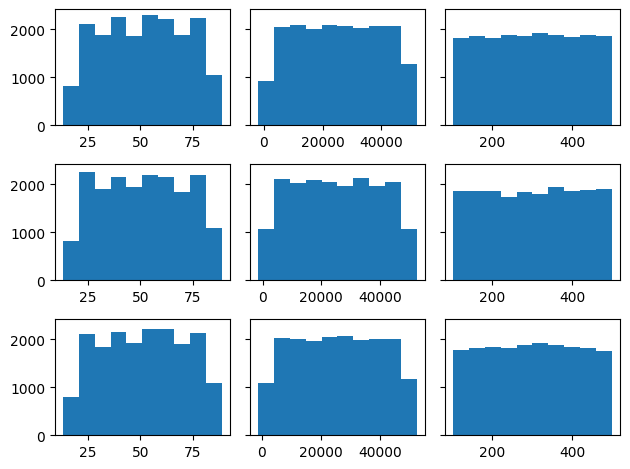

In [17]:
# plot histograms for numeric features and classes of target variable

fig, axs = plt.subplots(3, 3, sharey=True, tight_layout=True)

axs[0, 0].hist(df[df['Test Results']==0]['Age'])
axs[0, 1].hist(df[df['Test Results']==0]['Billing Amount'])
axs[0, 2].hist(df[df['Test Results']==0]['Room Number'])
axs[1, 0].hist(df[df['Test Results']==1]['Age'])
axs[1, 1].hist(df[df['Test Results']==1]['Billing Amount'])
axs[1, 2].hist(df[df['Test Results']==1]['Room Number'])
axs[2, 0].hist(df[df['Test Results']==2]['Age'])
axs[2, 1].hist(df[df['Test Results']==2]['Billing Amount'])
axs[2, 2].hist(df[df['Test Results']==2]['Room Number'])

plt.show()

---

## Model Card
This model card provides an overview of two models trained to predict test results using the [healthcare dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset?resource=download).

Since the dataset contains many categorical features with numerous unique categories, [CatBoost](https://catboost.ai/) and [XGBoost](https://xgboost.readthedocs.io/en/stable/) are chosen due to their native support for handling categorical data efficiently.

### Model Details
- Developed by: Sanath Haritsa
- Model:
  1. [CatBoost](https://catboost.ai/)
  2. [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- License: Apache 2.0
- Model Description: These models are designed to predict healthcare test results based on a person's personal data. They were developed using privacy-preserving techniques, and fairness measures have been calculated to ensure ethical use.
- Additional Resources:
  - [XGBoost with categorical features](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html)
  - [CatBoost with categorical features](https://datascience.stackexchange.com/a/109055)

### Training

#### Training Data
The models were trained on a subset of the healthcare dataset.

Since accuracy is not the primary objective of this project, only two key hyperparameters were used during training:
- iterations=100
- learning_rate=0.03

#### Training Procedure
- "Inconclusive" test results were removed from the dataset to convert the task into a binary classification problem.
- The following features were used for model training:
  - Name
  - Date of Admission
  - Doctor
  - Hospital
  - Gender
- Categorical columns were cast as ``category`` types to ensure proper processing by the models.

#### Privacy-Enhancing Methods
- **Pseudonymization:** Personal medical information, such as ``medical conditions`` and ``medications``, was excluded from the training data. This ensures that personal data cannot be linked to a specific individual without additional information.
- **Anonymization:** Personal data was transformed to a form that is unreadable by unauthorized users, providing additional privacy protection. ``Names`` are anonymised using cryptographic hash functions.

### Evaluation Results

|Model|Accuracy|
|---|---|
|Cat Boost|57.68%|
|XG Boost|51.99%|

### Intended Use

#### *Direct Use*
The models are primarily intended for educational and research purposes to predict healthcare test results based on personal information. They should not be used for purposes outside the intended scope as outlined in the Misuse and Out-of-Scope Use sections.

#### *Downstream Use*
The models may also be used for downstream tasks such as:
- Research to examine model limitations and biases, with the aim of advancing scientific understanding.
- Improving model performance through data engineering enhancements.
Downstream uses should avoid those mentioned in the Misuse and Out-of-Scope Use sections.

### Misuse
The model should not be used to conduct membership inference attacks, including attempts to deduce a person's medical condition or medication details.

### Out-of-Scope Use
The models were not designed to provide factual or accurate representations of individuals or events. Therefore, any attempt to use these models to predict such information falls outside the scope of their intended capabilities.

### Limitations
Due to the models being trained on synthetic data, their accuracy is relatively low (57%), making them unsuitable for real-world applications.

### Fairness Considerations
A comprehensive fairness analysis will be performed to assess the influence of 'Gender' on model predictions and to address any existing biases within the models.

### Environmental Impact
The models were trained on Google Colab, utilizing cloud-based CPUs. The environmental impact of this process is minimal due to Google's commitment to using renewable energy in its data centers. This translates to near-zero carbon emissions during training, with an estimated energy consumption of around 0.15 kWh per hour if running on standard grid electricity.

---

In [18]:
# function to evaluate given model. it calculates accuracy, classification report, and the confusion matrix

def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  print('Accuracy = {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
  print('Classification report')
  print(classification_report(y_test, y_pred))
  print('Confusion matrix')
  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Abnormal','Normal'])
  cm_display.plot()
  plt.show()

In [19]:
def anonymise(row):
  row['Name'] = hashlib.sha256(row['Name'].encode()).hexdigest()
  return row

In [20]:
# features for model training
cat_features = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Gender']

# omit inconclusive test results
df = df[df['Test Results']!=2]

# separate the dependent and independent variables
X = df[cat_features]
y = df['Test Results']

# anonymise the names
X = X.apply(lambda row: anonymise(row), axis=1)

# convert column dtype to category
for col in X.columns:
  X[col] = X[col].astype("category")

# random split into 75% train and 25% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Accuracy = 57.68%
Classification report
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      4656
           1       0.59      0.52      0.55      4630

    accuracy                           0.58      9286
   macro avg       0.58      0.58      0.58      9286
weighted avg       0.58      0.58      0.58      9286

Confusion matrix


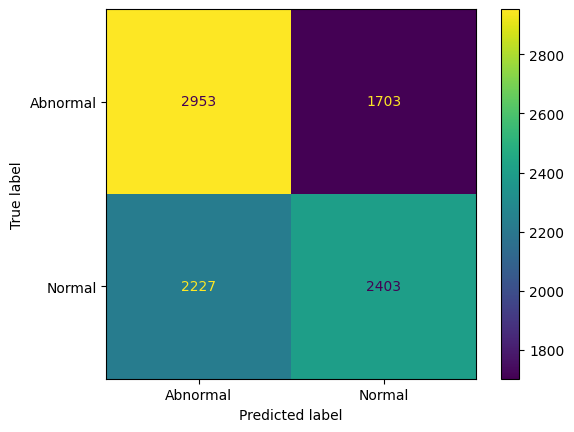

In [21]:
# train CATBOOST model

cat_boost = CatBoostClassifier(iterations=100, learning_rate=0.03, random_state=42)

cat_boost.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), verbose=0)

evaluate_model(cat_boost, X_test, y_test)

Accuracy = 52.04%
Classification report
              precision    recall  f1-score   support

           0       0.52      0.65      0.58      4656
           1       0.53      0.39      0.45      4630

    accuracy                           0.52      9286
   macro avg       0.52      0.52      0.51      9286
weighted avg       0.52      0.52      0.51      9286

Confusion matrix


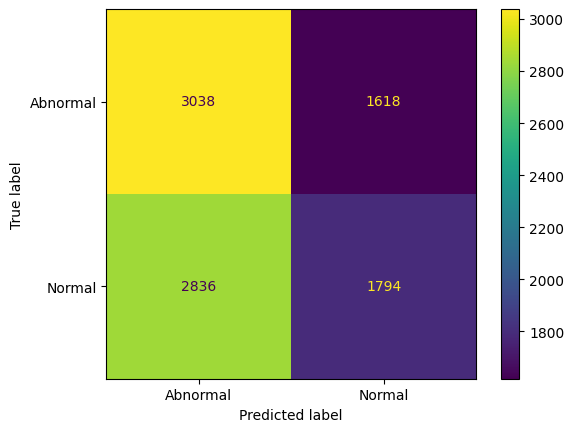

In [22]:
# train XGBOOST model

xg_boost = xgb.XGBClassifier(n_estimators=100, learning_rate=0.03, random_state=42, enable_categorical=True)

xg_boost.fit(X_train, y_train)

evaluate_model(xg_boost, X_test, y_test)

---

## Fairness

**Fairness** in machine learning refers to the idea that models and algorithms should treat individuals or groups equally and without bias, especially in sensitive areas such as race, gender, age, socioeconomic status, or other protected characteristics. The goal is to ensure that the decisions made by machine learning systems do not result in unfair advantages or disadvantages for any specific group of people.

In this case, "Male" and "Female" are considered the protected and unprotected groups under the "Gender" feature. Below are various fairness definitions and their corresponding calculations for both the CatBoost and XGBoost models.

### Definitions of fairness

#### Definitions Based on Predicted Outcome
1. Statistical Parity
  
  Satisfied if protected and unprotected groups have equal probability of being assigned to the positive predicted class.

2. Conditional Statistical Parity
  
  Satisfied if protected and unprotected groups have equal probability of being assigned to the positive predicted class, controlling for a set of legitimate factors L.

#### Definitions Based on Predicted and Actual Outcomes
1. Predictive Parity
  
  Satisfied if protected and unprotected groups have equal PPV - the probability of a subject with positive predictive value to truly belong to the positive class.

2. False positive error rate balance

   Satisfied if protected and unprotected groups have equal FDR – subject in the negative class to have a positive predictive value.

3. False negative error rate balance

  Satisfied if protected and unprotected groups have equal FNR – the probability of a subject in a positive class to have a negative predictive value.

4. Equalized odds

  Satisfied if protected and unprotected groups have equal TPR and FPR.

5. Conditional use accuracy equality

  Satisfied if equal PPV and NPV – the probability of subjects with positive predictive value to truly belong to the positive class and the probability of subjects with negative predictive value to truly belong to the negative class.

6. Overall accuracy equality

  Satisfied if equal prediction accuracy for positive and negative classes.

7. Treatment equality

  Satisfied if protected and unprotected groups have an equal ratio of false negatives and false positives.

#### Definitions Based on Predicted Probabilities and Actual Outcomes:

1. Well-calibration

  Satisfied if for any predicted probability score S, subjects in both protected and unprotected groups should not only have an equal probability to truly belong to the positive class, but this probability should be equal to S

2. Balance of classes (positive & negative)
  
  Satisfied if: subjects constituting positive/negative class from both protected and unprotected groups have equal average predicted probability score S

|Fairness Definition|CatBoost|XGBoost|
|---|---|---|
|Statistical Parity|&#x2718;|&#x2713;|
|Conditional Statistical Parity|&#x2713;|&#x2713;|
|Predictive Parity|&#x2718;|&#x2713;|
|False positive error rate balance|&#x2718;|&#x2713;|
|False negative error rate balance|&#x2718;|&#x2713;|
|Equalized odds|&#x2718;|&#x2713;|
|Conditional use accuracy equality|&#x2718;|&#x2718;|

> Protected and unprotected groups are said to have equal values if their difference is <1%.

---

In [23]:
# make separate predictions and confusion matrix for male and female samples

X_test_M = X_test[X_test['Gender']=='Male']
X_test_F = X_test[X_test['Gender']=='Female']

y_test_m = y_test[X_test['Gender']=='Male']
y_test_f = y_test[X_test['Gender']=='Female']

y_pred_cat_m = cat_boost.predict(X_test_M)
y_pred_cat_f = cat_boost.predict(X_test_F)

y_pred_xgb_m = xg_boost.predict(X_test_M)
y_pred_xgb_f = xg_boost.predict(X_test_F)

cm_cat_male = confusion_matrix(y_test_m, y_pred_cat_m)
cm_cat_female = confusion_matrix(y_test_f, y_pred_cat_f)

cm_xgb_male = confusion_matrix(y_test_m, y_pred_xgb_m)
cm_xgb_female = confusion_matrix(y_test_f, y_pred_xgb_f)

In [24]:
# statistical parity

print('CatBoost')
print('Probability of M being assigned to positive class = {:.2f}%'.format((len(y_pred_cat_m[y_pred_cat_m==class_map['Normal']])/len(y_pred_cat_m))*100))

print('Probability of F being assigned to positive class = {:.2f}%'.format((len(y_pred_cat_f[y_pred_cat_f==class_map['Normal']])/len(y_pred_cat_f))*100))

print('XGBoost')
print('Probability of M being assigned to positive class = {:.2f}%'.format((len(y_pred_xgb_m[y_pred_xgb_m==class_map['Normal']])/len(y_pred_xgb_m))*100))

print('Probability of F being assigned to positive class = {:.2f}%'.format((len(y_pred_xgb_f[y_pred_xgb_f==class_map['Normal']])/len(y_pred_xgb_f))*100))

CatBoost
Probability of M being assigned to positive class = 43.43%
Probability of F being assigned to positive class = 45.02%
XGBoost
Probability of M being assigned to positive class = 36.66%
Probability of F being assigned to positive class = 36.83%


In [25]:
# conditional statistical parity

conditional_statistical_parity_test_f = X_test_F.iloc[0:1,:]
conditional_statistical_parity_test_m = X_test_F.iloc[0:1,:]

conditional_statistical_parity_test_m['Gender'] = 'Male'

for col in conditional_statistical_parity_test_m.columns:
  conditional_statistical_parity_test_m[col] = conditional_statistical_parity_test_m[col].astype('category')
  conditional_statistical_parity_test_f[col] = conditional_statistical_parity_test_f[col].astype('category')

y_pred_cat_m = cat_boost.predict_proba(conditional_statistical_parity_test_m)
y_pred_cat_f = cat_boost.predict_proba(conditional_statistical_parity_test_f)

y_pred_xgb_m = xg_boost.predict_proba(conditional_statistical_parity_test_m)
y_pred_xgb_f = xg_boost.predict_proba(conditional_statistical_parity_test_f)

print('CatBoost')
print('Probability of M being assigned to positive class, controlling for a set of legitimate factors L = {:.2f}%'.format(float(y_pred_cat_m[0][class_map['Normal']]*100)))

print('Probability of F being assigned to positive class, controlling for a set of legitimate factors L = {:.2f}%'.format(float(y_pred_cat_f[0][class_map['Normal']]*100)))

print('XGBoost')
print('Probability of M being assigned to positive class, controlling for a set of legitimate factors L = {:.2f}%'.format(float(y_pred_xgb_m[0][class_map['Normal']]*100)))

print('Probability of F being assigned to positive class, controlling for a set of legitimate factors L = {:.2f}%'.format(float(y_pred_xgb_f[0][class_map['Normal']]*100)))

<ipython-input-25-c765f09e80ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conditional_statistical_parity_test_m['Gender'] = 'Male'
<ipython-input-25-c765f09e80ac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conditional_statistical_parity_test_m[col] = conditional_statistical_parity_test_m[col].astype('category')
<ipython-input-25-c765f09e80ac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

CatBoost
Probability of M being assigned to positive class, controlling for a set of legitimate factors L = 49.96%
Probability of F being assigned to positive class, controlling for a set of legitimate factors L = 49.95%
XGBoost
Probability of M being assigned to positive class, controlling for a set of legitimate factors L = 28.84%
Probability of F being assigned to positive class, controlling for a set of legitimate factors L = 28.84%


In [26]:
class CalculateFairness:

    def __init__(self, matrix):
        self.tp, self.tn, self.fp, self.fn = self._calculate_confusion_matrix_values(matrix)

    def _calculate_confusion_matrix_values(self, matrix):
        return matrix[1, 1], matrix[0, 0], matrix[0, 1], matrix[1, 0]

    def calculate_ppv(self):
        return (self.tp / (self.tp + self.fp)) *100

    def calculate_fdr(self):
        return (self.fp/(self.tp + self.fp)) *100

    def calculate_fnr(self):
        return (self.fn/(self.tp + self.fn)) *100

    def calculate_tpr(self):
        return (self.tp/(self.tp + self.fn)) *100

    def calculate_fpr(self):
        return (self.fp/(self.fp + self.tn)) *100

    def calculate_npv(self):
        return (self.tn/(self.tn + self.fn)) *100

In [27]:
cat_m_fairness = CalculateFairness(cm_cat_male)
cat_f_fairness = CalculateFairness(cm_cat_female)
xgb_m_fairness = CalculateFairness(cm_xgb_male)
xgb_f_fairness = CalculateFairness(cm_xgb_female)

In [28]:
# predictive parity

print("Cat Male PPV: {:.2f}%".format(cat_m_fairness.calculate_ppv()))
print("Cat Female PPV: {:.2f}%".format(cat_f_fairness.calculate_ppv()))

print("XGB Male PPV: {:.2f}%".format(xgb_m_fairness.calculate_ppv()))
print("XGB Female PPV: {:.2f}%".format(xgb_f_fairness.calculate_ppv()))

Cat Male PPV: 60.00%
Cat Female PPV: 57.07%
XGB Male PPV: 53.20%
XGB Female PPV: 51.95%


In [29]:
# false positive error rate balance

print("Cat Male FDR: {:.2f}%".format(cat_m_fairness.calculate_fdr()))
print("Cat Female FDR: {:.2f}%".format(cat_f_fairness.calculate_fdr()))

print("XGB Male FDR: {:.2f}%".format(xgb_m_fairness.calculate_fdr()))
print("XGB Female FDR: {:.2f}%".format(xgb_f_fairness.calculate_fdr()))

Cat Male FDR: 40.00%
Cat Female FDR: 42.93%
XGB Male FDR: 46.80%
XGB Female FDR: 48.05%


In [30]:
# false negative error rate balance

print("Cat Male FNR: {:.2f}%".format(cat_m_fairness.calculate_fnr()))
print("Cat Female FNR: {:.2f}%".format(cat_f_fairness.calculate_fnr()))

print("XGB Male FNR: {:.2f}%".format(xgb_m_fairness.calculate_fnr()))
print("XGB Female FNR: {:.2f}%".format(xgb_f_fairness.calculate_fnr()))

Cat Male FNR: 48.65%
Cat Female FNR: 47.51%
XGB Male FNR: 61.56%
XGB Female FNR: 60.92%


In [31]:
# Equalized odds

print("Cat Male TPR: {:.2f}%".format(cat_m_fairness.calculate_tpr()))
print("Cat Female TPR: {:.2f}%".format(cat_f_fairness.calculate_tpr()))

print("Cat Male FPR: {:.2f}%".format(cat_m_fairness.calculate_fpr()))
print("Cat Female FPR: {:.2f}%".format(cat_f_fairness.calculate_fpr()))

print("XGB Male TPR: {:.2f}%".format(xgb_m_fairness.calculate_tpr()))
print("XGB Female TPR: {:.2f}%".format(xgb_f_fairness.calculate_tpr()))

print("XGB Male FPR: {:.2f}%".format(xgb_m_fairness.calculate_fpr()))
print("XGB Female FPR: {:.2f}%".format(xgb_f_fairness.calculate_fpr()))

Cat Male TPR: 51.35%
Cat Female TPR: 52.49%
Cat Male FPR: 35.27%
Cat Female FPR: 37.86%
XGB Male TPR: 38.44%
XGB Female TPR: 39.08%
XGB Male FPR: 34.84%
XGB Female FPR: 34.67%


In [32]:
# Conditional use accuracy equality

print("Cat Male NPV: {:.2f}%".format(cat_m_fairness.calculate_npv()))
print("Cat Female NPV: {:.2f}%".format(cat_f_fairness.calculate_npv()))

print("XGB Male NPV: {:.2f}%".format(xgb_m_fairness.calculate_npv()))
print("XGB Female NPV: {:.2f}%".format(xgb_f_fairness.calculate_npv()))

Cat Male NPV: 56.36%
Cat Female NPV: 57.69%
XGB Male NPV: 50.67%
XGB Female NPV: 52.79%


---

## Explainabile AI

Explainable Artificial Intelligence (XAI) encompasses a range of techniques and methods designed to help human users understand and trust the outcomes generated by machine learning algorithms.

Why should users trust an AI system that often functions like a black box?

This section aims to shed light on the reasoning behind the XGBoost model predictions, offering insights into its decision-making process using *TreeShap*.

Target audience: Developers, and researchers.

### SHAP

[SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) is a game-theory-based approach to interpret the output of machine learning models. It assigns each feature a Shapley value, which represents its contribution to the model’s prediction by considering all possible combinations of feature inputs. SHAP provides a unified measure of feature importance, ensuring consistent and interpretable explanations for complex models.

#### TreeShap

[TreeSHAP](https://shap.readthedocs.io/en/latest/tabular_examples.html#tree-based-models) is an explainability method based on SHAP specifically designed for tree-based machine learning models like decision trees, random forests, and gradient-boosted trees. It provides a consistent and accurate way to attribute a model's output to individual features, helping users understand how each feature contributes to the predictions by computing the Shapley values in polynomial time, making it efficient for large datasets and complex models.

1. Global Explanations

Global explanations provide insights into the overall behavior of a machine learning model, showing how the model makes predictions across the entire dataset. These explanations help understand general trends and the importance of features on a broader scale.

|Feature|Mean Shap Value|
|---|---|
|Date of Admission|    0.27|
|Hospital|              0.03|
|Gender|            0.02|
|Doctor|                0.01|
|Name|               0.01|

2. Local Explanations

Local explanations, on the other hand, focus on individual predictions, explaining why the model made a specific decision for a particular instance. This allows users to understand model behavior on a case-by-case basis, offering personalized insights into specific outcomes.

Example 1:

- Predicted class: 1
- Actual class: 1

|Feature|Shap Value|
|---|---|
|Date of Admission|    0.485991|
|Gender|              -0.002991|
|Hospital|            -0.001530|
|Name|                -0.001119|
|Doctor|               0.000508|

> ``Date of Admission`` has a strong positive impact on this prediction.

Example 2:

- Predicted Class: 0
- Actual Class: 0

|Feature|Shap Value|
|---|---|
|Hospital            |-0.003880|
|Name                |-0.002154|
|Gender              | 0.000706|
|Doctor              |-0.000511|
|Date of Admission   | 0.000315|

> ``Hospital`` has a strong negative impact on this prediction.

---

In [33]:
# function to plot the shap values for a particular prediction
# the shap values are sorted by their absolute values - to see which feature has the strongest influence on the prediction
# bar plot shows clearly which features are having what kind of impact (sign and magnitude)

def plot_shap_values(shap_values, i, x_ticks=None):
  shaps = pd.Series(shap_values[i,:].values, index = x_sample.columns)
  indxs=shaps.abs().sort_values(ascending=False).index
  print(shaps[indxs])

  clrs = ['r' if i<0 else 'g' for i in shaps[indxs]]
  plt.barh(indxs,shaps[indxs], color=clrs)
  plt.title('Local Explanation')
  plt.xlabel('Shap value')
  plt.ylabel('Feature')
  if x_ticks: plt.xticks(x_ticks)
  plt.gca().invert_yaxis()
  plt.gca().xaxis.grid(True)
  plt.show()

In [34]:
# use a sample to generate predictions

x_sample = X_test.sample(1000, random_state=42)
y_sample = y_test.sample(1000, random_state=42)

In [35]:
y_pred = xg_boost.predict(x_sample)

In [36]:
# get the tree explainer and calculate shap values

explainer_shap = shap.TreeExplainer(xg_boost)
shap_values = explainer_shap(x_sample)

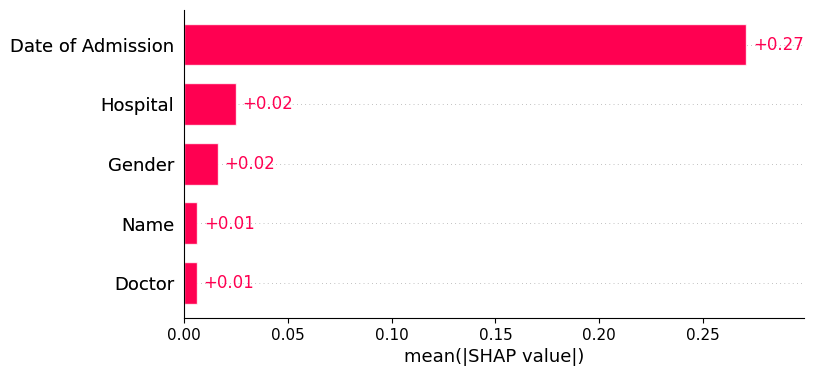

In [37]:
# global explanation

shap.plots.bar(shap_values)

In [38]:
# local explanation - example 1

i = 0

print(f'Prediction: {y_pred[i]}')
print(f'Actual: {y_sample.iloc[i]}')
shap.initjs()
shap.plots.force(shap_values[i,:])

Prediction: 1
Actual: 1


Date of Admission    0.486950
Gender              -0.001766
Hospital            -0.001588
Name                -0.001176
Doctor               0.000665
dtype: float32


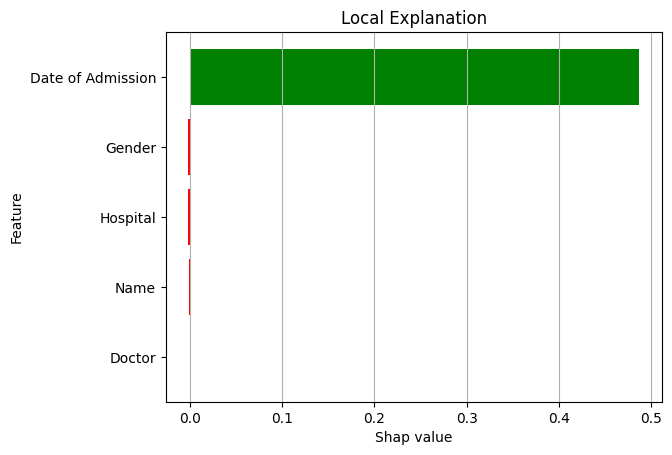

In [39]:
plot_shap_values(shap_values, i, [0, 0.1, 0.2, 0.3, 0.4, 0.5])

In [40]:
# local explanation - example 2

i = 2

print(f'Prediction: {y_pred[i]}')
print(f'Actual: {y_sample.iloc[i]}')
shap.initjs()
shap.plots.force(shap_values[i,:])

Prediction: 0
Actual: 0


Hospital            -0.003751
Name                -0.002148
Date of Admission    0.001585
Gender               0.000897
Doctor              -0.000276
dtype: float32


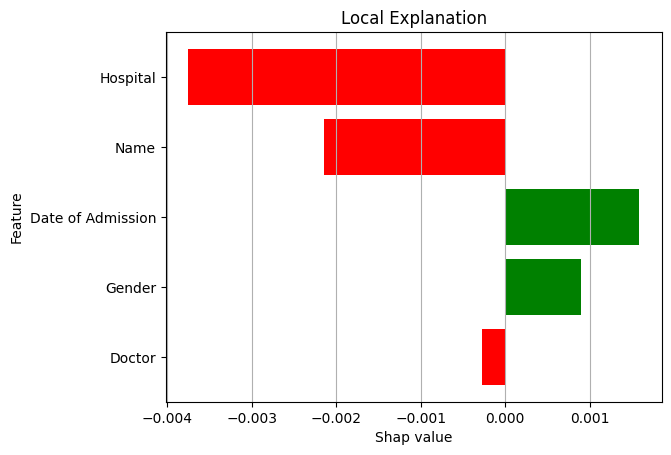

In [41]:
plot_shap_values(shap_values, i, [-0.004, -0.003, -0.002, -0.001, 0, 0.001])

---

## Conclusions

### 1. Model Performance
- The CatBoost model achieved an accuracy of 57.68%, while the XGBoost model scored 51.99% on the healthcare test result prediction task.
- These relatively low accuracies are expected given that the models were trained on a synthetic dataset and were not fine-tuned for performance. The focus of this project was more on responsible AI practices than model accuracy.

### 2. Fairness Analysis
- XGBoost demonstrated better fairness across multiple metrics compared to CatBoost. It satisfied Statistical Parity, Predictive Parity, False Positive Error Rate Balance, False Negative Error Rate Balance, and Equalized Odds. These metrics suggest that XGBoost treats protected and unprotected groups (Male and Female) more equally in terms of its predictions.
- CatBoost, on the other hand, failed to meet most fairness criteria, indicating potential bias in its predictions for different gender groups.

### 3. Explainability with SHAP (TreeShap)
These insights into the model’s decision-making process provide transparency and allow users to understand which factors most influence predictions.
- Global Explanations: The most important feature across the dataset was the Date of Admission, contributing significantly to the prediction of healthcare test results. Other features, such as Hospital and Gender, also had minor contributions.
- Local Explanations: Local SHAP values revealed that specific predictions were heavily influenced by features such as Date of Admission, which played a critical role in certain test result classifications. For example, one instance with a strong positive SHAP value for "Date of Admission" was key in classifying a test result as "Normal."

### 4. Privacy and Security
- The implementation of pseudonymization and anonymization techniques ensured that the training data did not include sensitive personal information, such as medical conditions or medications. By excluding these features, we reduced the risk of re-identifying patients or compromising their privacy. This approach aligns with the principles of **data minimization** and **privacy by design**, essential components of responsible AI development, especially in healthcare.

### 5. Limitations and Risk Management
- Synthetic Data: The dataset used for training is synthetic and not representative of real-world healthcare data. As a result, the models' predictive capabilities may not generalize well to actual healthcare scenarios, limiting their real-world applicability.
- Low Accuracy: Both models exhibit relatively low accuracy—CatBoost at 57.68% and XGBoost at 51.99%. This is significantly below what is acceptable for healthcare AI applications, where accuracy can directly impact patient outcomes. These models are currently only suitable for research purposes or educational use.
- Data Leakage: The "Discharge Date" feature is identified as a potential source of data leakage, as this information may not be available at the time of prediction. Including this feature could lead to misleading model performance and inaccurate results.

### 6. Responsible AI Principles
- This project adheres to key principles of Responsible AI as outlined in the introduction, including transparency, fairness, and privacy protection. The models were designed with minimal risk of AI hallucinations and included privacy-enhancing methods to mitigate risks associated with high-risk healthcare AI systems.
- Furthermore, the project aligns with the EU AI Act, ensuring that risk management, data governance, and transparency practices were embedded into the development process.
- Accountability tools like the Model Card and Datasheet have been used to thoroughly document the model's intended use, ethical considerations, and performance metrics, helping to guide responsible deployment and inform end-users.

---